In [1]:
import tensorflow as tf

# Clear any existing GPU settings
tf.keras.backend.clear_session()

# Set TensorFlow to run on GPU
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Allow memory growth to prevent OOM (Out-of-Memory) errors
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("GPU is set up successfully!")
    except RuntimeError as e:
        print(f"GPU Setup Error: {e}")

2025-04-30 10:01:23.743700: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746007283.951269      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746007284.009718      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


GPU is set up successfully!


In [2]:
import tensorflow as tf
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from pathlib import Path
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from collections import Counter
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import shuffle
from PIL import Image
import shutil

In [3]:
# Define dataset paths
dataset1_path = "/kaggle/input/lung-and-colon-cancer-histopathological-images/lung_colon_image_set/lung_image_sets"
dataset2_path = "/kaggle/input/iqothnccd-lung-cancer-dataset/The IQ-OTHNCCD lung cancer dataset/The IQ-OTHNCCD lung cancer dataset"
combined_dataset_path = "/kaggle/working/Combined_Lung_Dataset"

# Mapping folders to 3-class structure
datasets = {
    "lung_n": "Normal",
    "Normal cases": "Normal",
    "Bengin cases": "Benign",
    "lung_aca": "Malignant",
    "lung_scc": "Malignant",
    "Malignant cases": "Malignant",
}

# Make sure combined class folders exist
for category in set(datasets.values()):
    os.makedirs(os.path.join(combined_dataset_path, category), exist_ok=True)

# Function to copy & rename images with prefix
def copy_images(source_folder, target_folder, prefix):
    if os.path.exists(source_folder):
        for file in os.listdir(source_folder):
            if file.lower().endswith((".jpg", ".png", ".jpeg")):
                src_path = os.path.join(source_folder, file)
                new_filename = f"{prefix}_{file}"
                dst_path = os.path.join(target_folder, new_filename)
                shutil.copy(src_path, dst_path)

# Copy dataset 1 (H&E histology) → add "histo_" prefix
for folder, category in datasets.items():
    source_folder = os.path.join(dataset1_path, folder)
    target_folder = os.path.join(combined_dataset_path, category)
    copy_images(source_folder, target_folder, prefix="histo")

# Copy dataset 2 (CT scans) → add "ct_" prefix
for folder, category in datasets.items():
    source_folder = os.path.join(dataset2_path, folder)
    target_folder = os.path.join(combined_dataset_path, category)
    copy_images(source_folder, target_folder, prefix="ct")

# Cleanup: remove any empty folders
for category in set(datasets.values()):
    target_folder = os.path.join(combined_dataset_path, category)
    if len(os.listdir(target_folder)) == 0:
        print(f"Removing empty folder: {target_folder}")
        shutil.rmtree(target_folder)

print("✅ Dataset successfully merged into 3 classes: Normal, Benign, Malignant with histo/ct prefixes!")


✅ Dataset successfully merged into 3 classes: Normal, Benign, Malignant with histo/ct prefixes!


In [4]:
import os
import shutil

# === Paths ===
real_benign = "/kaggle/working/Combined_Lung_Dataset/Benign"
synthetic_benign = "/kaggle/input/gan-images-iq-othnccd-benign"
target_non_malignant = "/kaggle/working/Combined_Lung_Dataset/Non-Malignant"

# Create target folder
os.makedirs(target_non_malignant, exist_ok=True)

# === Copy Real Benign Images (prefix: real_) ===
for filename in os.listdir(real_benign):
    if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
        src = os.path.join(real_benign, filename)
        dst = os.path.join(target_non_malignant, f"real_{filename}")
        shutil.copyfile(src, dst)

# === Copy Synthetic Benign Images (prefix: ct_synthetic_) ===
for filename in os.listdir(synthetic_benign):
    if filename.lower().endswith('.png'):  # All synthetic are .png
        src = os.path.join(synthetic_benign, filename)
        dst = os.path.join(target_non_malignant, f"ct_synthetic_{filename}")
        shutil.copyfile(src, dst)

print(f"✅ Combined Real + Synthetic Benign images into: {target_non_malignant}")
print(f"🧾 Total: {len(os.listdir(target_non_malignant))} images")


✅ Combined Real + Synthetic Benign images into: /kaggle/working/Combined_Lung_Dataset/Non-Malignant
🧾 Total: 5120 images


In [5]:
# === Define paths ===
root_dataset = "/kaggle/working/Combined_Lung_Dataset"
normal_dir = os.path.join(root_dataset, "Normal")
benign_combined_dir = os.path.join(root_dataset, "Non-Malignant")  # this contains real + synthetic Benign
malignant_dir = os.path.join(root_dataset, "Malignant")

# Final binary class folder
final_dataset = "/kaggle/working/Final_Binary_Dataset"
final_non_malignant = os.path.join(final_dataset, "Non-Malignant")
final_malignant = os.path.join(final_dataset, "Malignant")

# === Create directories ===
os.makedirs(final_non_malignant, exist_ok=True)
os.makedirs(final_malignant, exist_ok=True)

# === Copy Normal images to Non-Malignant ===
for file in os.listdir(normal_dir):
    if file.lower().endswith(('.png', '.jpg', '.jpeg')):
        src = os.path.join(normal_dir, file)
        dst = os.path.join(final_non_malignant, f"normal_{file}")
        shutil.copyfile(src, dst)

# === Copy Benign (real + synthetic) to Non-Malignant ===
for file in os.listdir(benign_combined_dir):
    if file.lower().endswith('.png') or file.lower().endswith(('.jpg', '.jpeg')):
        src = os.path.join(benign_combined_dir, file)
        dst = os.path.join(final_non_malignant, file)
        shutil.copyfile(src, dst)

# === Copy Malignant images ===
for file in os.listdir(malignant_dir):
    if file.lower().endswith(('.png', '.jpg', '.jpeg')):
        src = os.path.join(malignant_dir, file)
        dst = os.path.join(final_malignant, file)
        shutil.copyfile(src, dst)

print("✅ Final Binary Dataset structure created at /kaggle/working/Final_Binary_Dataset")
print(f"📁 Non-Malignant: {len(os.listdir(final_non_malignant))} images")
print(f"📁 Malignant: {len(os.listdir(final_malignant))} images")


✅ Final Binary Dataset structure created at /kaggle/working/Final_Binary_Dataset
📁 Non-Malignant: 10536 images
📁 Malignant: 10561 images


In [6]:
import os
import numpy as np
from sklearn.model_selection import train_test_split

data_dir = "/kaggle/working/Final_Binary_Dataset"
np.random.seed(42)

image_paths = []
labels = []
synthetic_paths = []
synthetic_labels = []
label_dict = {}

# === Load image paths and separate synthetic ===
for idx, class_name in enumerate(sorted(os.listdir(data_dir))):
    class_dir = os.path.join(data_dir, class_name)
    if os.path.isdir(class_dir):
        label_dict[class_name] = idx
        for file in os.listdir(class_dir):
            full_path = os.path.join(class_dir, file)
            if class_name == "Non-Malignant" and file.startswith("synthetic_"):
                synthetic_paths.append(full_path)
                synthetic_labels.append(idx)
            else:
                image_paths.append(full_path)
                labels.append(idx)

image_paths = np.array(image_paths)
labels = np.array(labels)
synthetic_paths = np.array(synthetic_paths)
synthetic_labels = np.array(synthetic_labels)

# === Split real data into 70% train, 20% val, 10% test ===
X_temp, X_test, y_temp, y_test = train_test_split(
    image_paths, labels, test_size=0.1, stratify=labels, random_state=42)

X_train_real, X_val, y_train_real, y_val = train_test_split(
    X_temp, y_temp, test_size=2/9, stratify=y_temp, random_state=42)  # 2/9 of 90% → ~20%

# === Add synthetic data to training set only ===
X_train = np.concatenate((X_train_real, synthetic_paths))
y_train = np.concatenate((y_train_real, synthetic_labels))

# === Done ===
print("✅ 70/20/10 Split complete (synthetic used only in training).")
print(f"📦 Training Set: {len(X_train)} images (with synthetic)")
print(f"🧪 Validation Set: {len(X_val)} images (real only)")
print(f"🧫 Test Set: {len(X_test)} images (real only)")


✅ 70/20/10 Split complete (synthetic used only in training).
📦 Training Set: 14767 images (with synthetic)
🧪 Validation Set: 4220 images (real only)
🧫 Test Set: 2110 images (real only)


In [7]:
import numpy as np
from collections import Counter

def print_distribution(y, name=""):
    counts = Counter(y)
    total = len(y)
    print(f"📊 {name} Set Distribution:")
    for label, count in sorted(counts.items()):
        percentage = (count / total) * 100
        print(f"  Class {label} → {count} samples ({percentage:.2f}%)")
    print(f"  Total: {total} images\n")

# Example:
print_distribution(y_train, "Train")
print_distribution(y_val, "Validation")
print_distribution(y_test, "Test")


📊 Train Set Distribution:
  Class 0.0 → 7392 samples (50.06%)
  Class 1.0 → 7375 samples (49.94%)
  Total: 14767 images

📊 Validation Set Distribution:
  Class 0 → 2113 samples (50.07%)
  Class 1 → 2107 samples (49.93%)
  Total: 4220 images

📊 Test Set Distribution:
  Class 0 → 1056 samples (50.05%)
  Class 1 → 1054 samples (49.95%)
  Total: 2110 images



In [8]:
# Parameters
image_size = (256, 256)
mean = tf.convert_to_tensor([0.485, 0.456, 0.406], dtype=tf.float32)
std = tf.convert_to_tensor([0.229, 0.224, 0.225], dtype=tf.float32)

I0000 00:00:1746007488.932644      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


In [9]:
@tf.function
def augment_image(image, label, filename):
    # Apply base spatial transforms to all images
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)

    if tf.random.uniform([]) > 0.7:
        k = tf.random.uniform(shape=[], minval=0, maxval=4, dtype=tf.int32)
        image = tf.image.rot90(image, k)

    # === Conditional Augmentations ===
    # For histopathology images (H&E)
    if tf.strings.regex_full_match(filename, ".*histo.*|.*real.*"):
        if tf.random.uniform([]) > 0.7:
            image = tf.image.random_brightness(image, max_delta=0.08)
        if tf.random.uniform([]) > 0.7:
            image = tf.image.random_contrast(image, 0.9, 1.1)
        if tf.random.uniform([]) > 0.7:
            image = tf.image.random_saturation(image, 0.9, 1.1)
        if tf.random.uniform([]) > 0.9:
            image = tf.image.random_jpeg_quality(image, 80, 100)
        if tf.random.uniform([]) > 0.7:
            image = tf.image.central_crop(image, 0.9)
            image = tf.image.resize(image, [256, 256])
        if tf.random.uniform([]) > 0.7:
            noise = tf.random.normal(shape=tf.shape(image), mean=0.0, stddev=0.01)
            image = tf.clip_by_value(image + noise, 0.0, 1.0)

    # For CT/synthetic images
    elif tf.strings.regex_full_match(filename, ".*ct.*|.*synthetic.*"):
        # Less aggressive augmentations for CT
        if tf.random.uniform([]) > 0.8:
            image = tf.image.central_crop(image, 0.95)
            image = tf.image.resize(image, [256, 256])
        if tf.random.uniform([]) > 0.8:
            # Slight noise for CT images
            noise = tf.random.normal(shape=tf.shape(image), mean=0.0, stddev=0.002)
            image = tf.clip_by_value(image + noise, 0.0, 1.0)
        if tf.random.uniform([]) > 0.2:  # Small probability for brightness change for CT
            image = tf.image.random_brightness(image, max_delta=0.02)  # Small brightness for CT scans

    return image, label


In [10]:
# ================= Preprocessing Function ================= #
def load_and_preprocess_image(image_path, label, augment=False):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, image_size)
    print("Before normalization:", tf.reduce_min(img), tf.reduce_max(img))
    img = img / 255.0  # Normalize pixel values
    print("After division by 255:", tf.reduce_min(img), tf.reduce_max(img))
    # Apply augmentation only if augment=True
    if augment:
        img, label = augment_image(img, label, filename)
    print("After mean/std normalization:", tf.reduce_min(img), tf.reduce_max(img))
    img = (img - mean) / std  # Apply mean-std normalization
    img = tf.cast(img, tf.float32)
    return img, label

In [11]:
# ================= Dataset Creation ================= #
def create_dataset(image_paths, labels, batch_size=32, shuffle=True, augment=False):
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, labels))
    dataset = dataset.map(lambda x, y: load_and_preprocess_image(x, y, augment), num_parallel_calls=tf.data.AUTOTUNE)
    if shuffle:
        dataset = dataset.shuffle(len(image_paths))
    dataset = dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return dataset

In [12]:

# Create datasets
train_dataset = create_dataset(X_train, y_train, augment=True)  # Augmentation only in training
val_dataset = create_dataset(X_val, y_val, shuffle=False)
test_dataset = create_dataset(X_test, y_test, shuffle=False)


Before normalization: Tensor("Min:0", shape=(), dtype=float32) Tensor("Max:0", shape=(), dtype=float32)
After division by 255: Tensor("Min_1:0", shape=(), dtype=float32) Tensor("Max_1:0", shape=(), dtype=float32)
After mean/std normalization: Tensor("Min_2:0", shape=(), dtype=float32) Tensor("Max_2:0", shape=(), dtype=float32)
Before normalization: Tensor("Min:0", shape=(), dtype=float32) Tensor("Max:0", shape=(), dtype=float32)
After division by 255: Tensor("Min_1:0", shape=(), dtype=float32) Tensor("Max_1:0", shape=(), dtype=float32)
After mean/std normalization: Tensor("Min_2:0", shape=(), dtype=float32) Tensor("Max_2:0", shape=(), dtype=float32)
Before normalization: Tensor("Min:0", shape=(), dtype=float32) Tensor("Max:0", shape=(), dtype=float32)
After division by 255: Tensor("Min_1:0", shape=(), dtype=float32) Tensor("Max_1:0", shape=(), dtype=float32)
After mean/std normalization: Tensor("Min_2:0", shape=(), dtype=float32) Tensor("Max_2:0", shape=(), dtype=float32)


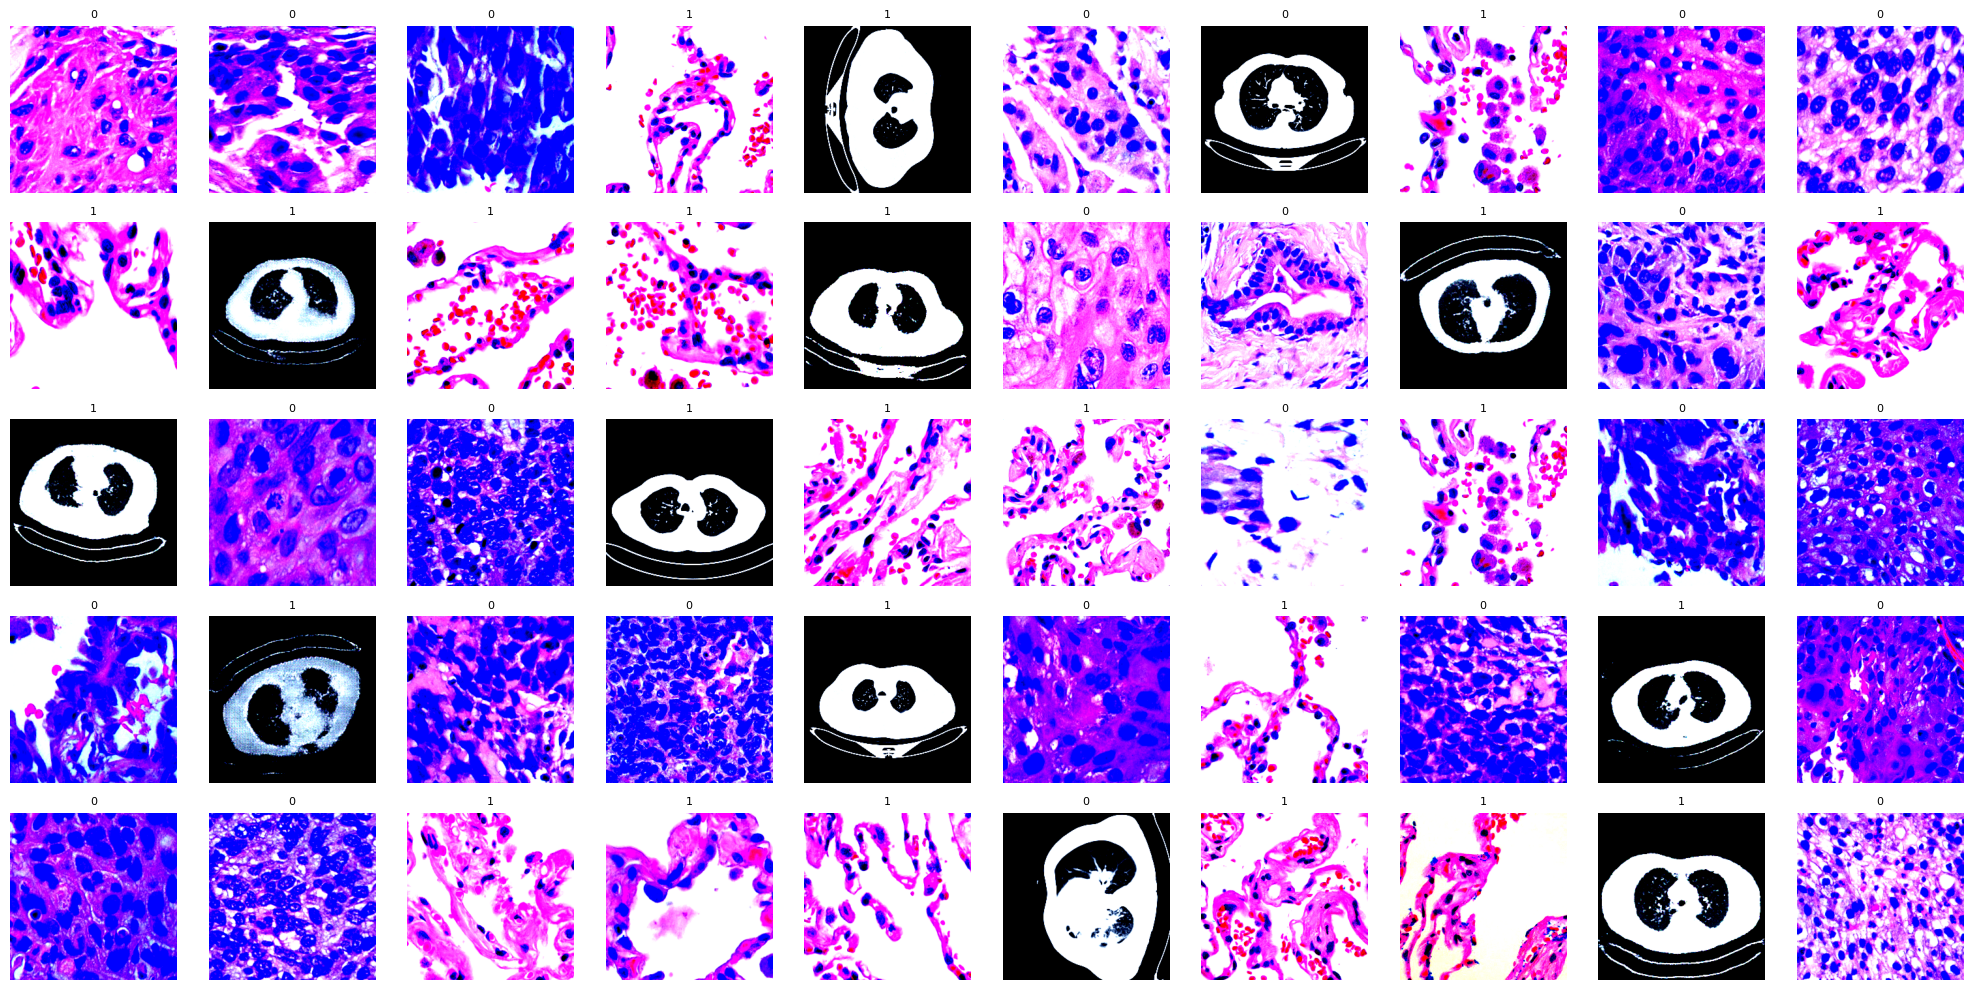

In [13]:
import matplotlib.pyplot as plt
import tensorflow as tf

# Take batches and flatten to 50 individual images
images = []
labels = []

# Collect 50 images
for batch_images, batch_labels in train_dataset:
    for i in range(len(batch_images)):
        images.append(batch_images[i])
        labels.append(batch_labels[i])
        if len(images) == 50:
            break
    if len(images) == 50:
        break

# Plot 50 images in a 10x5 grid
plt.figure(figsize=(20, 10))  # Adjust size as needed

for i in range(50):
    plt.subplot(5, 10, i + 1)
    plt.imshow(tf.clip_by_value(images[i], 0.0, 1.0).numpy())
    plt.title(f"{int(labels[i])}", fontsize=8)
    plt.axis("off")

plt.tight_layout()
plt.show()


In [14]:
'''
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler, ModelCheckpoint
from tensorflow.keras.optimizers import SGD, Adam
import matplotlib.pyplot as plt

# Function to create a residual block (for ResNet)
def residual_block(x, filters, kernel_size=3, stride=1, downsample=False):
    shortcut = x

    # First convolution layer
    x = layers.Conv2D(filters, kernel_size=kernel_size, strides=stride, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    # Second convolution layer
    x = layers.Conv2D(filters, kernel_size=kernel_size, strides=1, padding="same")(x)  # stride = 1 in second layer
    x = layers.BatchNormalization()(x)

    # If downsample is True, apply a 1x1 convolution to the shortcut path to match dimensions
    if downsample:
        shortcut = layers.Conv2D(filters, kernel_size=1, strides=stride, padding="same")(shortcut)
        shortcut = layers.BatchNormalization()(shortcut)

    # Add the shortcut to the output
    x = layers.Add()([x, shortcut])
    x = layers.ReLU()(x)
    return x

# ================== Model Builder ==================#
def create_resnet150(input_shape=(256, 256, 3), num_classes=1):
    base_model = tf.keras.applications.ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)
    base_model.trainable = False  # Freeze the base model initially

    # Define the input layer
    inputs = tf.keras.Input(shape=input_shape)

    # Initial Conv Layer
    x = layers.Conv2D(64, kernel_size=7, strides=2, padding="same")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    # Initial max pooling layer
    x = layers.MaxPooling2D(pool_size=3, strides=2, padding="same")(x)

    # ResNet blocks configuration (ResNet150 typically has more layers and blocks)
    block_configs = [(3, 64, 2), (4, 128, 2), (6, 256, 2), (3, 512, 2)]

    # Add residual blocks
    for num_blocks, filters, stride in block_configs:
        for i in range(num_blocks):
            x = residual_block(x, filters, stride=(stride if i == 0 else 1), downsample=(i == 0))

    # Global Average Pooling layer
    x = layers.GlobalAveragePooling2D()(x)

    # Fully connected layers
    x = layers.Dense(512, activation='relu')(x)
    x = layers.Dropout(0.5)(x)  # Dropout added to reduce overfitting
    final_output = layers.Dense(num_classes, activation='sigmoid')(x)
    
    model = models.Model(inputs, final_output)

    model.compile(
        optimizer=Adam(learning_rate=0.0001),  # Using Adam optimizer for smoother convergence
        loss='binary_crossentropy',  # Use binary cross entropy for binary classification
        metrics=['accuracy']
    )
    
    return model

# ================== Learning Rate Scheduler ==================#
def scheduler(epoch, lr):
    if epoch < 10:
        return lr  # Keep the learning rate constant for the first 10 epochs
    return lr * 0.8  # Reduce learning rate by 20% after 10 epochs

callback_lr = LearningRateScheduler(scheduler)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)
model_checkpoint = ModelCheckpoint("best_model_resnet150.keras", monitor='val_loss', save_best_only=True, verbose=1)

# ================== Get the Model ==================#
model = create_resnet150(input_shape=(256, 256, 3))

# ================== Train the Model ==================#
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=20,
    callbacks=[callback_lr, early_stopping, model_checkpoint],
    verbose=1
)

# ================== Evaluation ==================#
test_loss, test_acc = model.evaluate(test_dataset)
print(f"Test Accuracy: {test_acc * 100:.2f}%")
print(f"Test Loss: {test_loss:.4f}")

# ================== Plot Accuracy & Loss ==================#
plt.figure(figsize=(10, 6))

# Plot training vs validation accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy')
plt.legend()

# Plot training vs validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()

plt.show()

# ================== Save Final Model ==================#
model.save('/kaggle/working/resnet150_model.h5') 
'''

'\nimport tensorflow as tf\nfrom tensorflow.keras import layers, models\nfrom tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler, ModelCheckpoint\nfrom tensorflow.keras.optimizers import SGD, Adam\nimport matplotlib.pyplot as plt\n\n# Function to create a residual block (for ResNet)\ndef residual_block(x, filters, kernel_size=3, stride=1, downsample=False):\n    shortcut = x\n\n    # First convolution layer\n    x = layers.Conv2D(filters, kernel_size=kernel_size, strides=stride, padding="same")(x)\n    x = layers.BatchNormalization()(x)\n    x = layers.ReLU()(x)\n\n    # Second convolution layer\n    x = layers.Conv2D(filters, kernel_size=kernel_size, strides=1, padding="same")(x)  # stride = 1 in second layer\n    x = layers.BatchNormalization()(x)\n\n    # If downsample is True, apply a 1x1 convolution to the shortcut path to match dimensions\n    if downsample:\n        shortcut = layers.Conv2D(filters, kernel_size=1, strides=stride, padding="same")(shortcut)\n  

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/20


I0000 00:00:1746007592.342134      91 service.cc:148] XLA service 0x7f47c8004ac0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1746007592.343542      91 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1746007595.399146      91 cuda_dnn.cc:529] Loaded cuDNN version 90300


  2/462 ━━━━━━━━━━━━━━━━━━━━ 38s 84ms/step - accuracy: 0.4297 - loss: 6.0914   

I0000 00:00:1746007607.000376      91 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


462/462 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - accuracy: 0.9360 - loss: 4.3095
Epoch 1: val_loss improved from inf to 1.96525, saving model to best_model_resnet150.keras
462/462 ━━━━━━━━━━━━━━━━━━━━ 136s 132ms/step - accuracy: 0.9361 - loss: 4.3076 - val_accuracy: 0.9633 - val_loss: 1.9653 - learning_rate: 1.0000e-04
Epoch 2/20
462/462 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.9744 - loss: 1.5402
Epoch 2: val_loss improved from 1.96525 to 0.71224, saving model to best_model_resnet150.keras
462/462 ━━━━━━━━━━━━━━━━━━━━ 73s 96ms/step - accuracy: 0.9744 - loss: 1.5395 - val_accuracy: 0.9758 - val_loss: 0.7122 - learning_rate: 1.0000e-04
Epoch 3/20
462/462 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.9863 - loss: 0.5500
Epoch 3: val_loss improved from 0.71224 to 0.26344, saving model to best_model_resnet150.keras
462/462 ━━━━━━━━━━━━━━━━━━━━ 74s 99ms/step - accuracy: 0.9863 - loss: 0.5497 - val_accuracy: 0.9803 - val_loss: 0.2634 - learning_rate: 1.0000e-04
Epoch 4/20
462/462 ━━━━━━

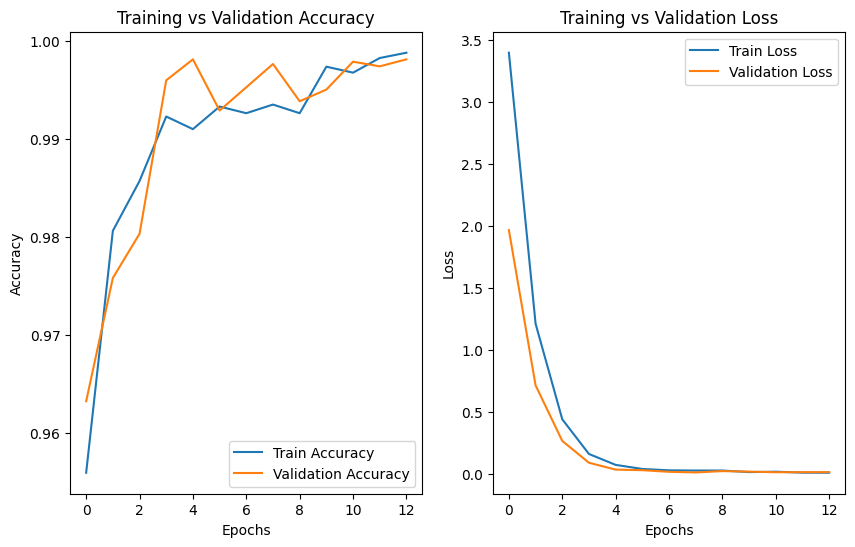

In [15]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

# Function to create a residual block (for ResNet)
def residual_block(x, filters, kernel_size=3, stride=1, downsample=False):
    shortcut = x

    # First convolution layer
    x = layers.Conv2D(filters, kernel_size=kernel_size, strides=stride, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    # Second convolution layer
    x = layers.Conv2D(filters, kernel_size=kernel_size, strides=1, padding="same")(x)  # stride = 1 in second layer
    x = layers.BatchNormalization()(x)

    # If downsample is True, apply a 1x1 convolution to the shortcut path to match dimensions
    if downsample:
        shortcut = layers.Conv2D(filters, kernel_size=1, strides=stride, padding="same")(shortcut)
        shortcut = layers.BatchNormalization()(shortcut)

    # Add the shortcut to the output
    x = layers.Add()([x, shortcut])
    x = layers.ReLU()(x)
    return x

# ================== Model Builder ==================#
def create_resnet150(input_shape=(256, 256, 3), num_classes=1):
    base_model = tf.keras.applications.ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)
    base_model.trainable = False  # Freeze the base model initially

    # Define the input layer
    inputs = tf.keras.Input(shape=input_shape)

    # Initial Conv Layer
    x = layers.Conv2D(64, kernel_size=7, strides=2, padding="same")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    # Initial max pooling layer
    x = layers.MaxPooling2D(pool_size=3, strides=2, padding="same")(x)

    # ResNet blocks configuration (ResNet150 typically has more layers and blocks)
    block_configs = [(3, 64, 2), (4, 128, 2), (6, 256, 2), (3, 512, 2)]

    # Add residual blocks
    for num_blocks, filters, stride in block_configs:
        for i in range(num_blocks):
            x = residual_block(x, filters, stride=(stride if i == 0 else 1), downsample=(i == 0))

    # Global Average Pooling layer
    x = layers.GlobalAveragePooling2D()(x)

    # Fully connected layers with L2 Regularization
    x = layers.Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
    x = layers.Dropout(0.5)(x)  # Dropout added to reduce overfitting
    final_output = layers.Dense(num_classes, activation='sigmoid')(x)
    
    model = models.Model(inputs, final_output)

    model.compile(
        optimizer=Adam(learning_rate=0.0001),  # Using Adam optimizer for smoother convergence
        loss='binary_crossentropy',  # Use binary cross entropy for binary classification
        metrics=['accuracy']
    )
    
    return model

# ================== Learning Rate Scheduler ==================#
def scheduler(epoch, lr):
    if epoch < 10:
        return lr  # Keep the learning rate constant for the first 10 epochs
    return lr * 0.8  # Reduce learning rate by 20% after 10 epochs

callback_lr = LearningRateScheduler(scheduler)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)
model_checkpoint = ModelCheckpoint("best_model_resnet150.keras", monitor='val_loss', save_best_only=True, verbose=1)

# ================== Get the Model ==================#
model = create_resnet150(input_shape=(256, 256, 3))

# ================== Train the Model ==================#
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=20,
    callbacks=[callback_lr, early_stopping, model_checkpoint],
    verbose=1
)

# ================== Evaluation ==================#
test_loss, test_acc = model.evaluate(test_dataset)
print(f"Test Accuracy: {test_acc * 100:.2f}%")
print(f"Test Loss: {test_loss:.4f}")

# ================== Plot Accuracy & Loss ==================#
plt.figure(figsize=(10, 6))

# Plot training vs validation accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy')
plt.legend()

# Plot training vs validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()

plt.show()

# ================== Save Final Model ==================#
model.save('/kaggle/working/resnet150_model.h5')


In [16]:
!zip -r /kaggle/working/resnet150_lung_model.zip /kaggle/working/resnet150_model.h5

  adding: kaggle/working/resnet150_model.h5 (deflated 9%)


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━

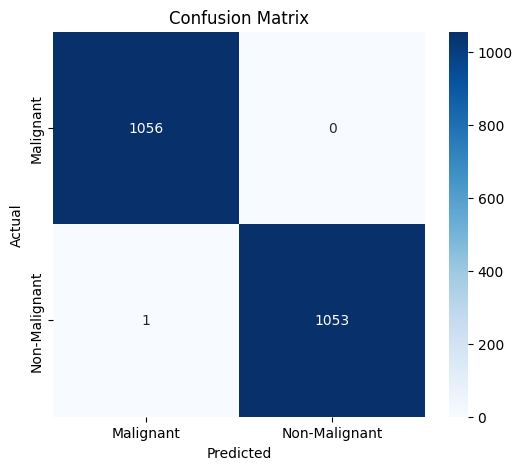

In [17]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, f1_score, precision_score, recall_score

# === Run Predictions ===
y_true = []
y_pred = []
y_prob = []

for x_batch, y_batch in test_dataset:
    probs = model.predict(x_batch).flatten()
    preds = (probs > 0.5).astype(int)

    y_true.extend(y_batch.numpy().astype(int))
    y_pred.extend(preds)
    y_prob.extend(probs)

y_true = np.array(y_true)
y_pred = np.array(y_pred)
y_prob = np.array(y_prob)

# === Metrics ===
accuracy = np.mean(y_true == y_pred)
f1 = f1_score(y_true, y_pred, average='macro')
precision = precision_score(y_true, y_pred, average='macro')
recall = recall_score(y_true, y_pred, average='macro')
auroc = roc_auc_score(y_true, y_prob)

# === Confusion Matrix ===
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Malignant", "Non-Malignant"], yticklabels=["Malignant", "Non-Malignant"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.savefig('/kaggle/working/confusion_matrix.png')  # Save confusion matrix as an image

# === Save Results to a Text File ===
with open('/kaggle/working/model_evaluation.txt', 'w') as f:
    f.write("✅ Model Evaluation Metrics:\n")
    f.write(f"Accuracy     : {accuracy * 100:.2f}%\n")
    f.write(f"Macro F1     : {f1:.4f}\n")
    f.write(f"Precision    : {precision:.4f}\n")
    f.write(f"Recall       : {recall:.4f}\n")
    f.write(f"AUROC        : {auroc:.4f}\n")
    
    f.write("\nClassification Report:\n")
    f.write(classification_report(y_true, y_pred, target_names=["Malignant", "Non-Malignant"]))

# === Print Results ===
print("✅ Model Evaluation Metrics:")
print(f"Accuracy     : {accuracy * 100:.2f}%")
print(f"Macro F1     : {f1:.4f}")
print(f"Precision    : {precision:.4f}")
print(f"Recall       : {recall:.4f}")
print(f"AUROC        : {auroc:.4f}")


In [18]:
import shutil

# Move the files to the correct location for downloading
shutil.move('/kaggle/working/confusion_matrix.png', '/kaggle/working/your_confusion_matrix.png')
shutil.move('/kaggle/working/model_evaluation.txt', '/kaggle/working/your_model_evaluation.txt')

'/kaggle/working/your_model_evaluation.txt'

In [19]:
plt.savefig('accuracy_graph.png')  # or 'accuracy_graph.jpg

<Figure size 640x480 with 0 Axes>